# Summarizes Vectrino output 

This notebooks is a starter for working with the ASCII output from the Vectrino stored in the .dat files. 

## Loads

In [1]:
# %pylab inline
import numpy as np
from numpy import log, sin, cos, exp, tan, pi
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

%matplotlib inline
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment while working

# uncomment the two lines below when exporting to a pdf
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png','pdf')

## Functions

In [19]:
#returns the clear-water density in kg/m^3 as a function of temperature [in deg C] and salinity [ppt]
def rho_cw(T,S): 
    rho_fresh=1000*(1-(T +288.9414)/(508929.2*(T+68.12963))*(T-3.9863)**2)
    Acoef = 0.824493 - 0.0040899*T + 0.000076438*T**2 -0.00000082467*T**3 + 0.0000000053675*T**4
    Bcoef = -0.005724 + 0.00010227*T - 0.0000016546*T**2
    return rho_fresh + Acoef*S + Bcoef*S**(3/2) + 0.00048314*S**2 

# returns the clear water kinimatic viscosity in [m^2/s] as a function of temperature [in deg C].
def visc(T):
    return 2.7488e-07+1.4907e-06*exp(-0.034812*T)

def swlogfit(z, ustar):
    Bs = 5.5
    return (ustar/kappa)*log(ustar*z/nu)+ustar*Bs

def rwlogfit(z, ks, ustar):
    Br = 8.5
    z0 = 0.25*ks
    # z0 = 0
    return (ustar/kappa)*log((z+z0)/ks)+ustar*Br

def rwlogfit2(z, z0, ks, ustar):
    Br = 8.5
    # z0 = 0.25*ks
    # z0 = 0
    return (ustar/kappa)*log((z+z0)/ks)+ustar*Br

## Find the data files and prep for loading the files 

In [3]:
""" --- User input ----------------------------- """

fs = 25 # frequency in Hz that the data was recorded at
h_cm = 8.4 # flow depth in cm

T = 10 # water temperature in deg C

cf = 70 # correlation filter, drop everything below
snrf = 10

datadir = 'ADV_test/' # path to the data
zfile = 'Z_values.csv'

"""  ------------------------------------------- """

ext = '*.dat'     # data file extension

fig_folder = 'Figures'
# Make the output folder
if os.path.isdir(fig_folder) != 1:
    os.mkdir(fig_folder)

# Specify the column header names in the *.dat files. These names can be found in the .hrd file.

cnames = ['time_s','status','v1_m_s', 'v2_m_s','v3_m_s','v4_m_s','amp1', 'amp2','amp3','amp4',
         'snr1', 'snr2','snr3','snr4','cor1', 'cor2','cor3','cor4']

# Find all of the data files and store the names 

files = sorted(glob.glob(datadir+ext))
nf=len(files)
os.chdir(datadir)
filenames = sorted(glob.glob(ext))
for i in range(0,nf):
    filenames[i]=os.path.splitext(os.path.basename(filenames[i]))[0] #strips extension
os.chdir("..")
    
#strip the endings 

datapt=filenames.copy()
for i in range(0,len(filenames)):
    stname = filenames[i]
    datapt[i]=stname[0:8]
    
# load the z values

zdata = pd.read_csv(datadir+zfile) # reads in the data
# z_h=np.array(zdata.z_cm.copy()/h_cm) # create a scaled z value
# zdata['z_h']=z_h  # add the scaled z value to the dataframe
    
#Print the file names and index value for each file

for i in range(0,nf):
    print('file: ',filenames[i],'(index: ',i,')')

file:  Sample0120220110135739 (index:  0 )
file:  Sample0220220110140125 (index:  1 )
file:  Sample0320220110140425 (index:  2 )
file:  Sample0420220110140710 (index:  3 )
file:  Sample0520220110140934 (index:  4 )
file:  Sample0620220110141151 (index:  5 )
file:  Sample0720220110141456 (index:  6 )
file:  Sample08_up20220110141746 (index:  7 )


## Process and summarize all data in profile

In [4]:
for j in range(nf):
    
    # load up the file
    data = pd.read_csv(files[j], sep='\s+', header=None) # reads in the data
    data.columns = cnames # renames the columns
    data.iloc[:,0]=np.arange(len(data))/fs # changes the counter to time
    data=data.drop(['status'], axis=1)  # delete the "status" column
    
    # filter based on cor and snr
    data = data[(data.cor1 >= cf)&(data.cor2 >= cf)&(data.cor3 >= cf)&(data.cor3 >= cf)
            &(data.snr1 >= snrf)&(data.snr2 >= snrf)&(data.snr3 >= snrf)&(data.snr4 >= snrf)].copy()
    
    # calculate the means and store in a new dataframe
    if j == 0:
        summary_mean = pd.DataFrame([data.mean()])
    else:
        summary_mean.loc[len(summary_mean.index)]=data.mean()

# clean up the dataframe column names and add in the z values
summary_mean.rename(columns={'time_s': 'z_cm'},inplace=True)
summary_mean.rename(columns={'v1_m_s': 'uavg_m_s', 'v2_m_s': 'vavg_m_s', 'v3_m_s': 'wavg_m_s'},inplace=True)
summary_mean = summary_mean.drop(columns=['v4_m_s'])
summary_mean['z_cm']=zdata.z_cm
summary_mean=summary_mean.sort_values(by=['z_cm']).reset_index(drop=True)

# save the summary file as a csv
summary_mean.to_csv(datadir+'averages_processed.csv')

# print out the summary file
summary_mean

,z_cm,uavg_m_s,vavg_m_s,wavg_m_s,amp1,amp2,amp3,amp4,snr1,snr2,snr3,snr4,cor1,cor2,cor3,cor4
0,1.6,0.306018,0.022176,0.029746,174.536201,165.397133,169.547670,148.205018,19.248674,21.427527,17.344731,17.837634,82.140502,80.156989,83.052330,78.555556
1,2.6,0.380203,0.017311,0.023575,171.362548,160.187261,169.856801,147.820881,19.085345,21.143774,17.362452,17.814464,84.422893,84.042625,83.227011,78.393678
2,3.8,0.476411,0.032536,-0.002412,172.849955,162.316410,171.518586,147.900272,19.162965,21.265458,17.449547,17.820580,84.973255,84.919311,82.117407,78.424297
3,4.8,0.482882,0.023039,-0.006691,174.881733,164.504098,171.275176,148.647541,19.267272,21.383899,17.436241,17.865925,87.317330,86.819672,77.313817,82.992974
4,6.8,0.540232,0.019915,0.006200,173.989984,163.633814,170.558093,148.645433,19.221915,21.338982,17.400160,17.863862,86.042067,86.037260,84.514022,79.944311
5,8.8,0.581737,0.019496,0.005958,175.112293,164.941686,171.563436,149.228526,19.279866,21.406974,17.451340,17.897951,86.427502,86.799842,84.371552,84.068558
6,10.8,0.626430,0.013015,0.009386,176.802585,166.835879,172.450059,149.813161,19.364826,21.509244,17.496514,17.932197,85.506463,85.415590,84.269095,83.903251
7,12.0,0.685315,0.013582,-0.000069,177.969639,168.114143,172.830515,148.470023,19.423098,21.575135,17.516180,17.828286,86.553420,86.971560,84.764412,82.690238


## Plot the profile

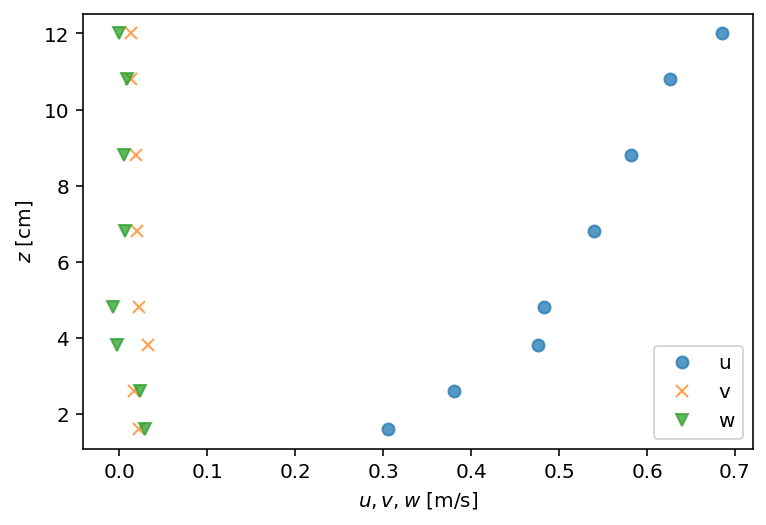

In [5]:
# plot the profiles

# fig, ax = plt.subplots() # don't specify the size
fig, ax = plt.subplots()
ax.plot(summary_mean.uavg_m_s,summary_mean.z_cm, 'o', alpha=0.75, label='u')
ax.plot(summary_mean.vavg_m_s,summary_mean.z_cm,'x', alpha=0.75, label='v')
ax.plot(summary_mean.wavg_m_s,summary_mean.z_cm, 'v', alpha=0.75, label='w')
ax.set_xlabel('$u,v,w$ [m/s]')
ax.set_ylabel('$z$ [cm]')
# ax.set_ylim(-0.25,0.7)
# ax.text(0,-0.2, datapt[j]+' ($z/h =$'+str(np.around(zdata.z_h[j],decimals=2))+')', backgroundcolor='none', clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
plt.legend(loc='best', ncol=1)
plt.savefig(fig_folder+'/profile_avg_'+datapt[j]+'_.pdf',bbox_inches="tight", pad_inches=0.005);

## Analysis

The depth average velocity is = 0.53 [m/s]
u* [m/s] = 0.0716
ks [m] = 0.0925
ks+ = 4987.0
R^2 = 0.979


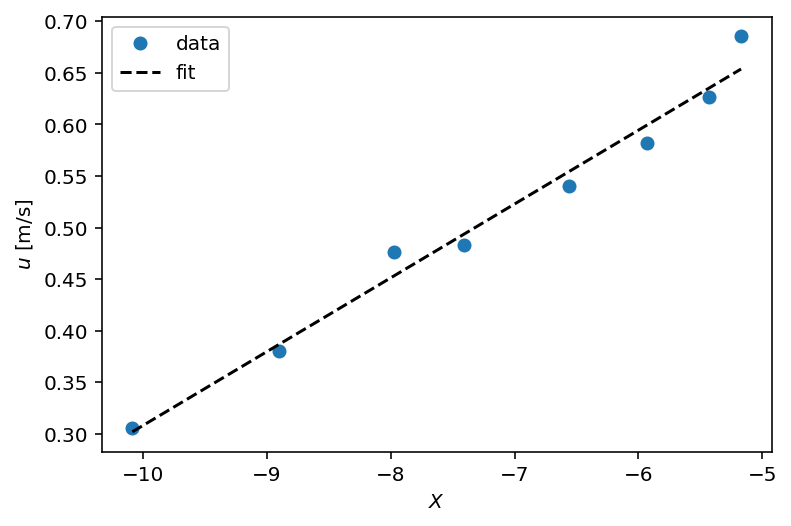

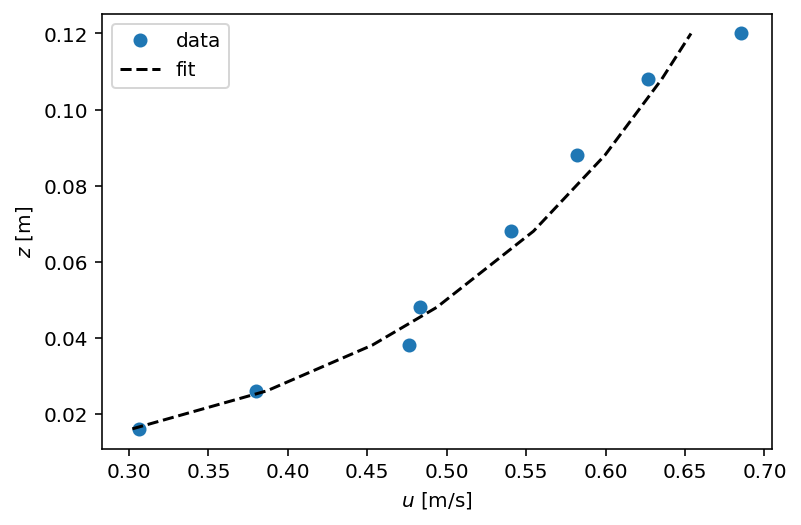

In [11]:
# create 1D arrays for ease
u=np.array(summary_mean.uavg_m_s.copy())
z=np.array(summary_mean.z_cm.copy()/100)

# depth avg vel
Uavg = np.trapz(u,z)/(z[-1]-z[0]) # depth average u for the profile
print('The depth average velocity is =',np.around(Uavg,decimals=2),'[m/s]')

# profile analysis
B = 8.5
kappa = 0.41
nu = visc(T)
rho = rho_cw(T,0)

X = (1/kappa)*log(z) # create loged velocity variable
slope, intercept, r_value, p_value, std_err = stats.linregress(X,u)

ustar = slope
ks = exp(kappa*(B-(intercept/ustar)))
u_calc=ustar*((1/kappa)*log(z/ks)+B)

fig, ax = plt.subplots()
ax.plot(X,u, 'o',label='data')
ax.plot(X,slope*X+intercept, '--k', label='fit')
ax.set_xlabel('$X$')
ax.set_ylabel('$u$ [m/s]')
plt.legend()

fig, ax = plt.subplots()
ax.plot(u,z,'o',label='data')
ax.plot(u_calc,z, '--k',label='fit')
plt.legend()
ax.set_xlabel('$u$ [m/s]')
ax.set_ylabel('$z$ [m]');

print('u* [m/s] =', np.around(ustar, decimals=4))
print('ks [m] =', np.around(ks, decimals=5))
print('ks+ =', np.around(ustar*ks/nu, decimals=0))
print('R^2 =', np.around(r_value**2, decimals=4))

Try a different method of curve fitting that accounts for the zero velocity displacement height

u* [m/s] = 0.0818
z0 [m] = 0.00596
ks [m] = 0.15197
ks+ = 9371.0


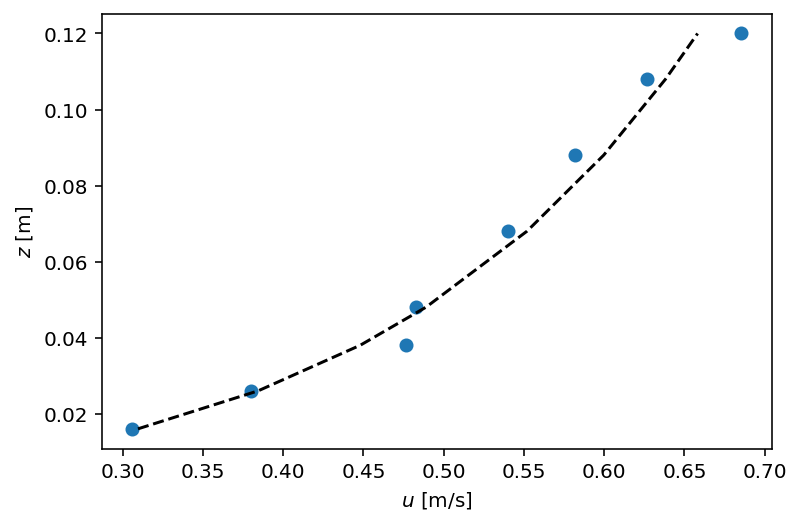

In [22]:
popt, pcov = curve_fit(rwlogfit2,z,u, bounds=(0, [1, 1, 1])) # popt is "ustar" from the fit
print('u* [m/s] =', np.around(popt[2], decimals=4))
print('z0 [m] =', np.around(popt[0], decimals=5))
print('ks [m] =', np.around(popt[1], decimals=5))
print('ks+ =', np.around(popt[1]*popt[2]/nu, decimals=0))

fig, ax = plt.subplots()
ax.plot(u,z, 'o')
ax.plot(popt[2]*((1/kappa)*log((z+popt[0])/popt[1])+B),z, '--k')
ax.set_xlabel('$u$ [m/s]')
ax.set_ylabel('$z$ [m]');

with $z_0$ tided to $k_s$, i.e., $z_0 = 0.25k_s$

u* [m/s] = 0.0553
ks [m] = 0.04746
ks+ = 1977.0


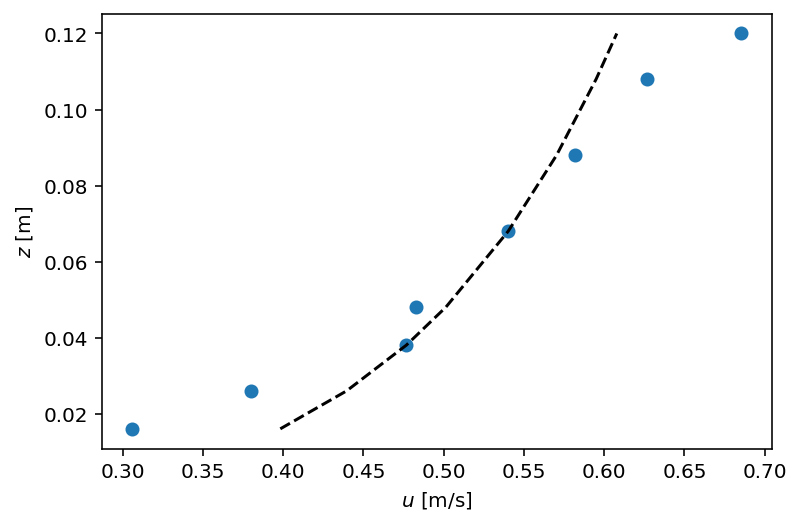

In [23]:
popt, pcov = curve_fit(rwlogfit,z,u, bounds=(0, [0.1, 0.1])) # popt is "ustar" from the fit
print('u* [m/s] =', np.around(popt[1], decimals=4))
print('ks [m] =', np.around(popt[0], decimals=5))
print('ks+ =', np.around(popt[1]*popt[0]/nu, decimals=0))

fig, ax = plt.subplots()
ax.plot(u,z, 'o')
# ax.plot(popt[1]*((1/kappa)*log((z+0*popt[0])/popt[0])+B),z, '--k')
ax.plot(popt[1]*((1/kappa)*log((z+0.25*popt[0])/popt[0])+B),z, '--k')
ax.set_xlabel('$u$ [m/s]')
ax.set_ylabel('$z$ [m]');